In [4]:
import os,requests,json,folium,re,datetime
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from math import asin,atan,atan2,cos,degrees,radians,sin,pi
from statistics import mean
pd.set_option('display.max_columns',None)

[Colorado Avalanche Fatalities Data](https://avalanche.state.co.us/sites/default/files/2022-11/Accidents_2022_PUBLIC.xlsx)

TODO:
- Get Data
  - use **requests**
  - to df
- Clean Data
  - address NA <- could be a problem
  - parse *Description*
  - do something with weather (request passes date and location to get weather conditions)
- Plots
  - Map
    - icons for *TravelMode*
    - 
  - Plot along Time ("Wow, more snow accidents occur when there is snow")
  - Plot by Activity/Travel
  - 

### Get Data

In [5]:
a_req = requests.get('https://avalanche.state.co.us/sites/default/files/2022-11/Accidents_2022_PUBLIC.xlsx')
df = pd.read_excel(a_req.content)
df = df.replace('SKi','Ski')
df = df.replace(['Mechanised Guide','Motorized Guided client','Mechanized Guide'],'Mechanized Guiding Client')
df['Date'] = df.Date.dt.date
pdf = df.dropna(subset=['lat','lon'],how='all')
pdf = pdf[(pdf.lat != 0) & (pdf.lon != 0)]
pdf.reset_index()
print(f'Entities of Full Dataset: {len(df)}\nEntities of Dataset with Lat/Lon: {len(pdf)}')

Entities of Full Dataset: 956
Entities of Dataset with Lat/Lon: 297


### Get Elevation
[USGS Elevation](https://apps.nationalmap.gov/epqs/)

**This Takes Sometime (~25mins)**

In [24]:
def getEle(elat,elon):
  el_url = r'https://epqs.nationalmap.gov/v1/json?'
  el_pars = {
    'output':'json',
    'x':elon,
    'y':elat,
    'units':'Meters'
  }    
  rtn = requests.get(el_url,el_pars).json()['value']
  return float(rtn)

def getSlope(ilat,ilon):
  orgn = getEle(ilat,ilon)
  eR = 6378160
  rlat = radians(ilat)
  rlon = radians(ilon)
  ele = []
  ele.append(orgn)
  for i,d in enumerate([10,25,50]):
    cord = []
    for e,b in enumerate([0,90*(pi/180),180*(pi/180),270*(pi/180)]):
      v = radians(b)
      nlat = degrees(asin(sin(rlat)*cos(d/eR)+cos(rlat)*sin(d/eR)*cos(v)))
      nlon = degrees(rlon + atan2(sin(v)*sin(d/eR)*cos(rlat),cos(d/eR)-sin(rlat)*sin(nlat)))
      nel = getEle(nlat,nlon)
      cord.append(degrees(atan((abs(orgn-nel))/d)))
    ele.append(max(cord))
  return ele
    

In [25]:
elst = []
sl10m = []
sl25m = []
sl50m = []
cnt = 0
for tpl in zip(pdf.lat,pdf.lon):
  cnt += 1
  if cnt%100 == 0:
    print(cnt)
  lat = tpl[0]
  lon = tpl[1]
  rtn = getSlope(tpl[0],tpl[1])
  elst.append(rtn[0])
  sl10m.append(rtn[1])
  sl25m.append(rtn[2])
  sl50m.append(rtn[3])
pdf['elevation'] = elst
pdf['slope_10m'] = sl10m
pdf['slope_25m'] = sl25m
pdf['slope_50m'] = sl50m

100
200


In [23]:
pdf.sample(10)

,AvyYear,YYYY,MM,DD,Location,Trigger,D Size,Setting,State,lat,lon,PrimaryActivity,TravelMode,Killed,Description,Date,elevation,slope_10m,slope_25m,precipitation_sum,windspeed_max,apparent_temperature_max,apparent_temperature_min,apparent_temperature_avg,precipitation_sum_7d,apparent_temperature_max_7d,apparent_temperature_min_7d,apparent_temperature_avg_7d,slope_50m
60,2020,2019,12,15,"Dutch Draw, Park City Ridgeline",AR,2.0,BC,UT,40.653470,-111.591260,Sidecountry Rider,Snowboard,1,"1 sidecountry rider caught, buried, and killed",2019-12-15,2874.200684,18.746179,20.705515,0.2,8.5,-15.3,-22.3,-18.80,52.7,-7.3,-22.3,-12.664286,19.080423
405,2004,2004,4,9,SAWATCH RANGE / BROWNS PEAK,NaN,NaN,BC,CO,38.959804,-106.448074,Hiker,Snowshoe,1,NaN,2004-04-09,3701.583252,27.978383,30.644257,6.3,13.8,-5.5,-12.5,-9.00,76.6,0.3,-12.8,-6.357143,23.660132
72,2019,2019,2,16,"Pearl Pass Road, Brush Creek Drainage",AS,2.0,BC,CO,38.900249,-106.871974,Backcountry Tourer,Ski,2,"2 backcountry tourers caught, buried, and killed",2019-02-16,2810.867920,3.939857,13.041479,9.1,14.3,-10.9,-18.5,-14.70,40.5,-4.7,-24.4,-12.885714,26.603087
109,2017,2017,2,14,"Near West Lost Lake, Flat Tops Wilderness area",NaN,NaN,BC,CO,40.074440,-107.242270,Snowbiker,Snowbike,1,"2 snow bike riders caught, 1 buried and killed",2017-02-14,3189.452881,8.622402,9.103370,0.0,8.7,-7.1,-13.9,-10.50,44.8,-0.8,-13.9,-7.171429,17.510129
180,2014,2014,1,7,"East Vail, backcountry southeast of Vail Ski Area",NaN,NaN,BC,CO,39.601260,-106.301230,Sidecountry Rider,Ski,1,"4 riders caught, 1 injured, 1 killed",2014-01-07,3601.339111,2.814962,2.496157,0.3,13.4,-11.0,-27.2,-19.10,16.0,-11.0,-32.9,-21.850000,15.504139
118,2016,2016,4,11,"Summit Lake area, Eastern Alaska Range",NaN,NaN,BC,AK,63.135430,-145.546880,Snowmobiler,Snowmobile,1,"1 snowmobiler caught, buried, killed",2016-04-11,979.500000,0.000000,0.000000,0.0,9.6,-2.1,-9.3,-5.70,6.8,-1.0,-12.7,-5.892857,0.000000
138,2016,2016,1,16,"Skyscraper Mountain, Hatcher Pass",NaN,NaN,BC,AK,61.773340,-149.307630,Backcountry Tourer,Snowboard,1,1 backcountry snowboarder fully buried and killed,2016-01-16,1255.592041,39.895574,43.830715,0.0,9.0,-17.7,-23.6,-20.65,2.0,-11.2,-24.3,-16.228571,39.825351
191,2013,2013,3,3,"Takhinsha Mountains, southwest of Haines",NaN,NaN,BC,AK,59.234280,-135.448380,Mechanized Guiding Client,Snowboard,1,"4 heliskiers caught in cornice fall, 2 injured...",2013-03-03,18.719999,0.916653,0.045838,0.0,3.9,-2.1,-9.5,-5.80,81.9,0.2,-9.5,-3.407143,0.584399
338,2007,2007,3,13,Mount Shimer,NaN,NaN,BC,CO,39.100219,-106.731148,Backcountry Tourer,Ski,1,NaN,2007-03-13,3451.885742,29.232212,31.297477,0.0,15.3,3.0,-6.7,-1.85,13.3,5.8,-15.9,-7.978571,31.663318
174,2014,2014,2,11,"SW face of Cornucopia Peak, Wallowa Mountains",NaN,NaN,BC,OR,45.049270,-117.247470,Human-powered Guide Client,Ski,2,"5 backcountry skiers caught, 1 uninjured, 2 in...",2014-02-11,2657.199707,31.619520,31.754028,2.5,8.4,-9.0,-15.1,-12.05,25.7,-9.0,-32.8,-20.021429,31.846176


### Get Weather
[Open-Metro Weather API](https://open-meteo.com/en/docs/)

Get Day of Data


**This Takes Sometime (~3mins)**

In [9]:
w_url = 'https://archive-api.open-meteo.com/v1/archive'
precip = []
wind_max = []
atemp_max = []
atemp_min = []
atemp_avg = []
for i,r in enumerate(pdf.iterrows()):
  w_pars = {
    'timezone':'auto',
    'latitude':r[1].lat,
    'longitude':r[1].lon,
    'start_date':r[1].Date,
    'end_date':r[1].Date,
    'daily':['precipitation_sum','apparent_temperature_max','apparent_temperature_min','windspeed_10m_max'],
  }
  w_dat = requests.get(w_url,params=w_pars).json()['daily']
  precip.append(w_dat['precipitation_sum'][0])
  wind_max.append(w_dat['windspeed_10m_max'][0])
  atemp_max.append(w_dat['apparent_temperature_max'][0])
  atemp_min.append(w_dat['apparent_temperature_min'][0])
  atemp_avg.append((w_dat['apparent_temperature_max'][0]+w_dat['apparent_temperature_min'][0])/2)
pdf['precipitation_sum'] = precip
pdf['windspeed_max'] = wind_max
pdf['apparent_temperature_max'] = atemp_max
pdf['apparent_temperature_min'] = atemp_min
pdf['apparent_temperature_avg'] = atemp_avg


Get Data of previous week (7 Days)

**This Takes Sometime (~3min)**

In [10]:
w_url = 'https://archive-api.open-meteo.com/v1/archive'
precip7d = []
atemp_max7d = []
atemp_min7d = []
atemp_avg7d = []
for i,r in enumerate(pdf.iterrows()):
  w_pars = {
    'timezone':'auto',
    'latitude':r[1].lat,
    'longitude':r[1].lon,
    'start_date':r[1].Date-datetime.timedelta(days=7),
    'end_date':r[1].Date,
    'daily':['precipitation_sum','apparent_temperature_max','apparent_temperature_min'],
  }
  w_dat = requests.get(w_url,params=w_pars).json()['daily']
  precip7d.append(sum(w_dat['precipitation_sum']))
  atemp_max7d.append(max(w_dat['apparent_temperature_max']))
  atemp_min7d.append(min(w_dat['apparent_temperature_min']))
  atemp_avg7d.append(mean([(w_dat['apparent_temperature_max'][idx]+w_dat['apparent_temperature_min'][idx])/2 for idx in range(7)]))
pdf['precipitation_sum_7d'] = precip7d
pdf['apparent_temperature_max_7d'] = atemp_max7d
pdf['apparent_temperature_min_7d'] = atemp_min7d
pdf['apparent_temperature_avg_7d'] = atemp_avg7d


### Get Geo

In [11]:
geo_us = gpd.read_file('https://raw.githubusercontent.com/python-visualization/folium/main/tests/us-states.json')
gdf = pd.merge(pdf,geo_us,left_on='State',right_on='id',how='left')

In [12]:
pdf

,AvyYear,YYYY,MM,DD,Location,Trigger,D Size,Setting,State,lat,lon,PrimaryActivity,TravelMode,Killed,Description,Date,elevation,slope_10m,slope_25m,precipitation_sum,windspeed_max,apparent_temperature_max,apparent_temperature_min,apparent_temperature_avg,precipitation_sum_7d,apparent_temperature_max_7d,apparent_temperature_min_7d,apparent_temperature_avg_7d
0,2022,2022,5,29,"Mount Meeker, Rocky Mountain National Park",N,3.0,BC,CO,40.253370,-105.600944,Climber,Foot,1,"3 climbers caught, 1 partially buried, 1 injur...",2022-05-29,3736.536377,10.034790,15.775504,5.4,18.1,3.0,-8.6,-2.80,15.6,7.2,-19.2,-4.964286
1,2022,2022,4,25,"Ice Face, southeast of Thompson Pass, Chugach ...",AS,2.0,BC,AK,61.126299,-145.727162,Mechanized Guiding Client,Ski,1,"1 skier caught, carried over cliff, and killed",2022-04-25,799.410034,2.519403,5.528966,0.0,5.1,-0.0,-10.1,-5.05,13.0,0.8,-14.4,-6.942857
2,2022,2022,3,19,"North Fork of Fish Creek, near Steamboat Springs",AS,2.0,BC,CO,40.505660,-106.720470,Backcountry Tourer,Ski,1,"1 backcountry skier caught, partially buried-c...",2022-03-19,2968.158691,22.704834,31.433322,0.0,11.6,-3.6,-18.4,-11.00,14.2,-2.1,-21.3,-11.614286
3,2022,2022,3,17,"Pilot Knob, east of Lizard Head Pass",AR,2.5,BC,CO,37.811000,-107.838000,Backcountry Tourer,Snowboard,1,"1 backcountry snowboarder caught, buried, and ...",2022-03-17,3622.571289,1.770346,4.176188,4.1,17.0,-10.9,-17.4,-14.15,13.2,-1.1,-26.7,-13.107143
4,2022,2022,3,17,"Game Creek Drainage, east of Victor Idaho",AS,2.5,BC,WY,43.594646,-111.011139,Backcountry Tourer,Ski,1,"2 skiers caught, 2 fully buried, 1 injured, an...",2022-03-17,2458.494141,15.853718,13.235156,0.0,10.8,-5.6,-13.3,-9.45,14.0,-2.0,-24.2,-12.214286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2000,2000,4,21,ABASIN MARJORIE BOWL,NaN,NaN,SA,CO,39.639007,-105.864685,Sidecountry Rider,Ski,1,NaN,2000-04-21,3482.666016,8.978948,6.119692,0.0,12.3,5.0,-10.8,-2.90,14.1,5.0,-16.6,-7.400000
507,2000,2000,3,17,ASPEN HIGHLANDS,NaN,NaN,SA,CO,39.130912,-106.888649,Backcountry Tourer,Ski,2,NaN,2000-03-17,3125.795898,23.591796,19.510568,2.3,16.2,-5.4,-18.0,-11.70,17.9,-3.2,-23.5,-11.992857
515,2000,2000,1,23,JONES PASS,NaN,NaN,BC,CO,39.774241,-105.889061,Hiker,Snowshoe,1,NaN,2000-01-23,3793.301758,7.688997,2.692708,1.2,20.3,-16.7,-27.2,-21.95,14.8,-5.8,-27.2,-15.221429
519,2000,1999,12,21,QUANDARY PEAK,NaN,NaN,BC,CO,39.389972,-106.097374,Backcountry Tourer,Ski,1,NaN,1999-12-21,3621.929932,27.103003,28.072342,1.5,9.7,-18.5,-30.4,-24.45,12.4,-9.8,-35.7,-22.750000


### Get Plots

All Deaths (including missing location)

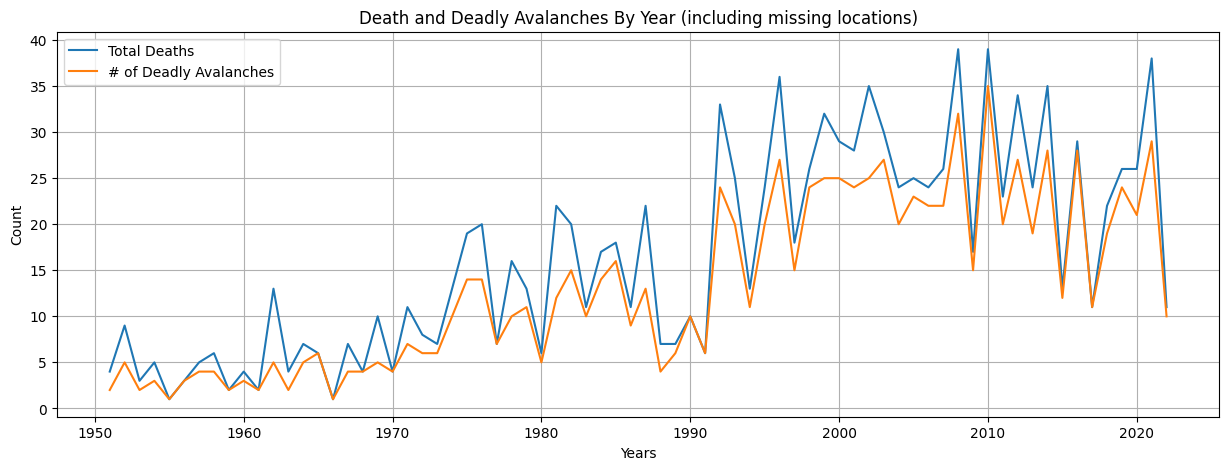

In [13]:
dead = df.groupby('YYYY')['Killed'].sum()
avlc = df.groupby('YYYY')['Killed'].count()
plt.figure(figsize=(15,5))
plt.plot(dead,label='Total Deaths')
plt.plot(avlc,label='# of Deadly Avalanches')
plt.title('Death and Deadly Avalanches By Year (including missing locations)')
plt.xlabel('Years')
plt.ylabel('Count')
plt.legend()
plt.grid()


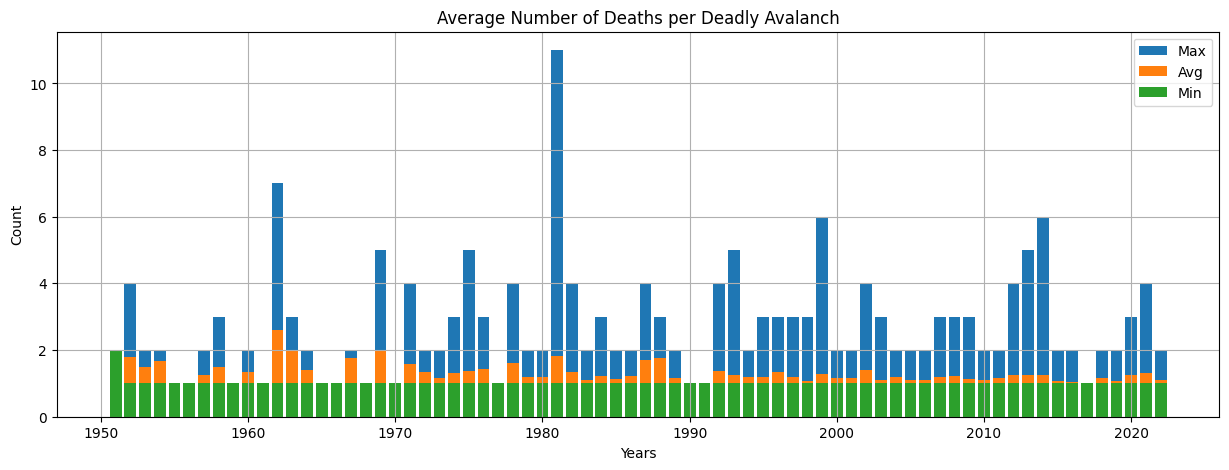

In [14]:
avg = dead/avlc
dmin = df.groupby('YYYY')['Killed'].min()
dmax = df.groupby('YYYY')['Killed'].max()
plt.figure(figsize=(15,5))
plt.bar(dead.index,dmax,label='Max')
plt.bar(dead.index,avg,label='Avg')
plt.bar(dead.index,dmin,label='Min')
plt.title('Average Number of Deaths per Deadly Avalanch')
plt.xlabel('Years')
plt.ylabel('Count')
plt.legend()
plt.grid()


[Mt Rainier Avalanche](https://www.historylink.org/file/10796)

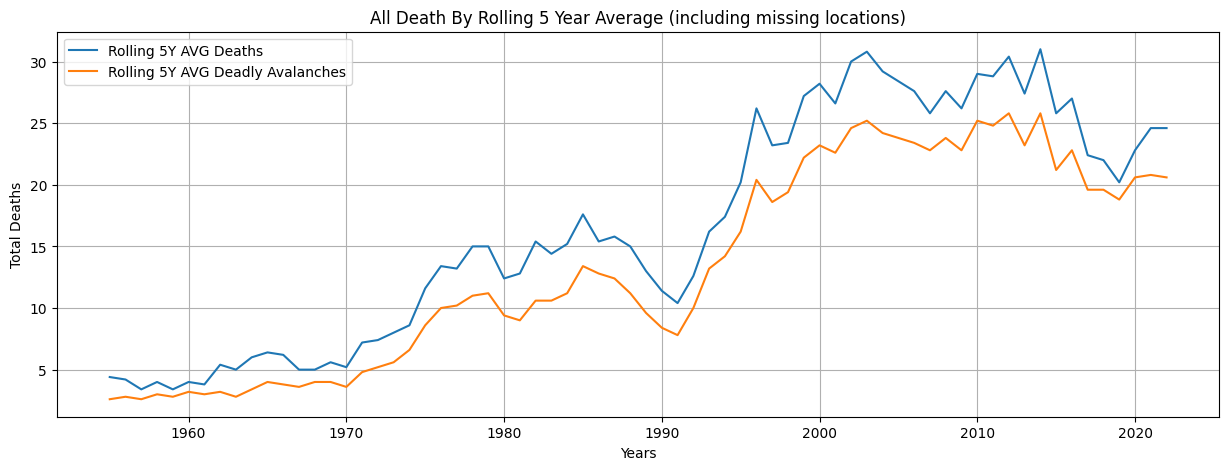

In [15]:
rdead = df.groupby('YYYY')['Killed'].sum().rolling(5).mean()
ravlc = df.groupby('YYYY')['Killed'].count().rolling(5).mean()
plt.figure(figsize=(15,5))
plt.plot(rdead,label='Rolling 5Y AVG Deaths')
plt.plot(ravlc,label='Rolling 5Y AVG Deadly Avalanches')
plt.title('All Death By Rolling 5 Year Average (including missing locations)')
plt.xlabel('Years')
plt.ylabel('Total Deaths')
plt.legend()
plt.grid()


By States

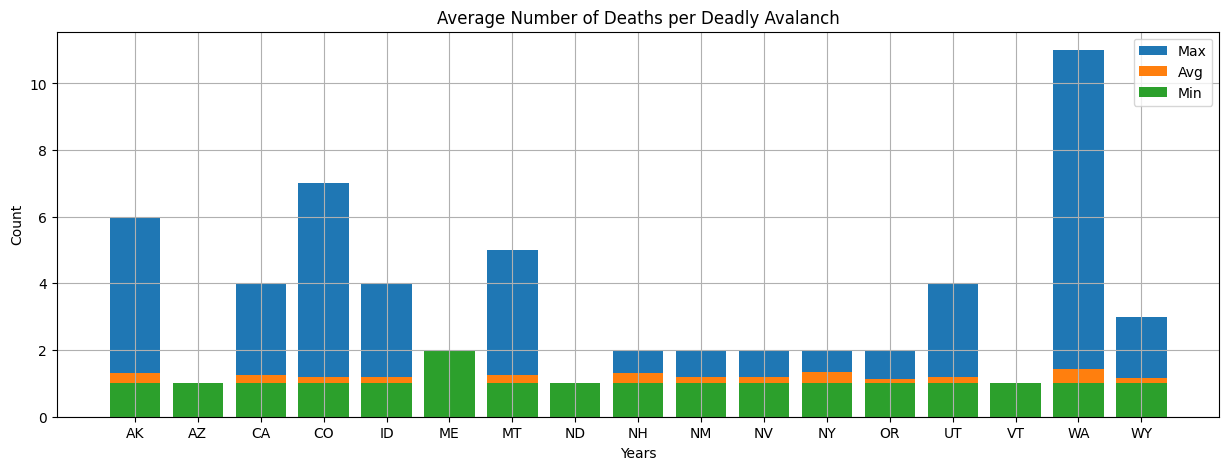

In [16]:
avg = df.groupby('State')['Killed'].sum()/df.groupby('State')['Killed'].count()
dmin = df.groupby('State')['Killed'].min()
dmax = df.groupby('State')['Killed'].max()
plt.figure(figsize=(15,5))
plt.bar(avg.index,dmax,label='Max')
plt.bar(avg.index,avg,label='Avg')
plt.bar(avg.index,dmin,label='Min')
plt.title('Average Number of Deaths per Deadly Avalanch')
plt.xlabel('Years')
plt.ylabel('Count')
plt.legend()
plt.grid()


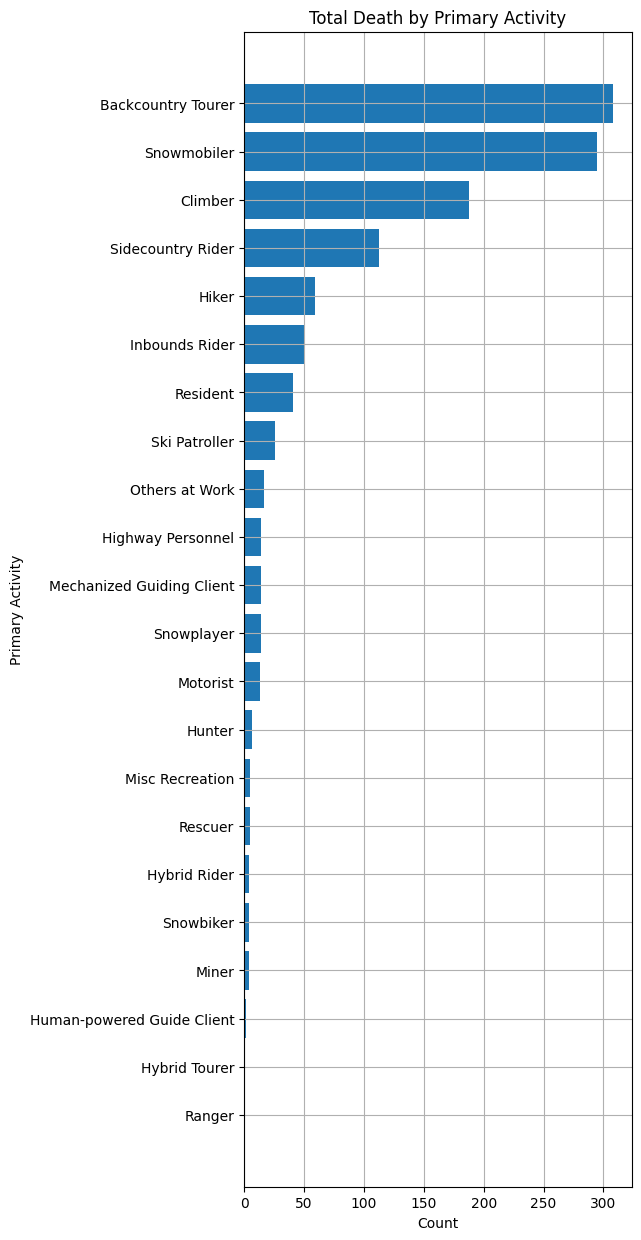

In [17]:
act = df.groupby('PrimaryActivity')['Killed'].sum().sort_values()
plt.figure(figsize=(5,15))
plt.barh(act.index,act)
plt.title('Total Death by Primary Activity')
plt.xlabel('Count')
plt.ylabel('Primary Activity')
plt.grid()

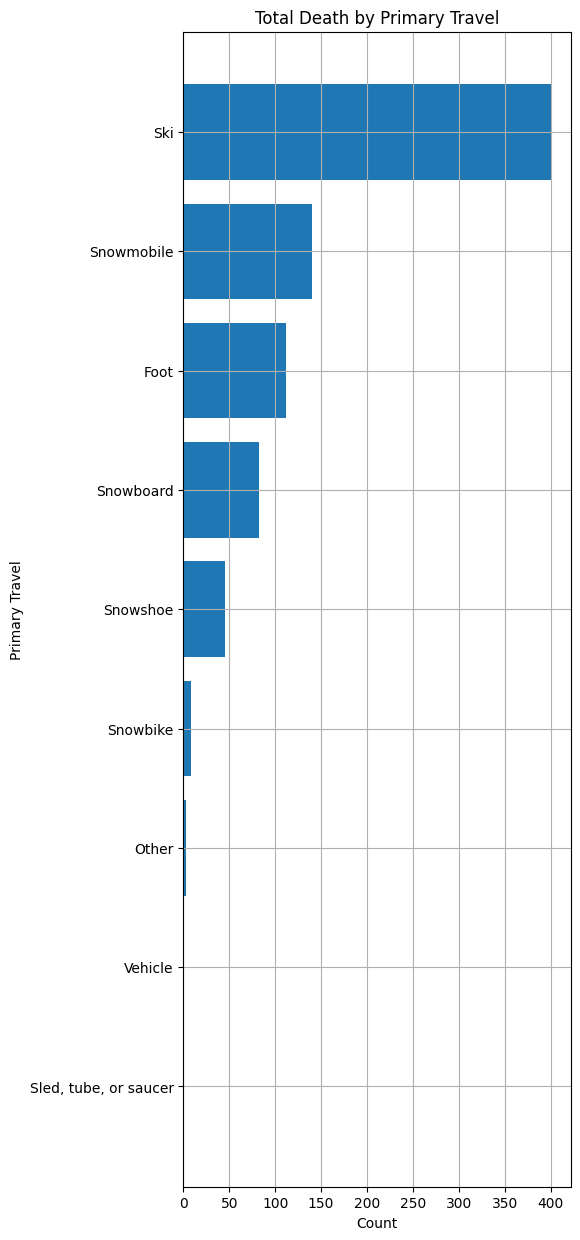

In [18]:
tvl = df.groupby('TravelMode')['Killed'].sum().sort_values()
plt.figure(figsize=(5,15))
plt.barh(tvl.index,tvl)
plt.title('Total Death by Primary Travel')
plt.xlabel('Count')
plt.ylabel('Primary Travel')
plt.grid()

In [ ]:
pdf.isna().sum()

In [ ]:
x = 'State'
y = 'precipitation_sum'
plt.figure(figsize=(10,10))
plt.scatter(pdf[x],pdf[y])
plt.title(f'{x} by {y}')
plt.xlabel(x)
plt.ylabel(y)
plt.grid()

### Get Map

[Icons](https://fontawesome.com/v4/)

In [ ]:
m = folium.Map(
  location=[39,-105],
  zoom_start=3,
  tiles='stamenterrain'
)
for r in pdf.iterrows():
  coord = [r[1]['lat'],r[1]['lon']]
  m.add_child(folium.Marker(
    location=coord,
    popup=
      "Date: "+str(r[1]['Date'])+"<br>"
      "State: "+str(r[1]['State'])+"<br>"
      "Activity: "+str(r[1]['PrimaryActivity'])+"<br>"
      "Latitude: "+str(r[1]['lat'])+"<br>"
      "Longitude: "+str(r[1]['lon']),
    icon=folium.Icon(color='red',prefix='fa',icon='exclamation-triangle')
  ))
folium.GeoJson(geo_us,name='geojson').add_to(m)
m

In [ ]:
pdf.head()
from prettytable import PrettyTable

killed = df.groupby(df.AvyYear)['Killed'].sum()
killeddf = pd.DataFrame(killed)
print(killeddf)



fig = px.line(killeddf, y="Killed",
              color_discrete_sequence = ['orchid'],
              title='Killed by Year')
fig.show()

fig = px.bar(killeddf, y="Killed",
              color = 'Killed',
              title='Killed by Year')
fig.show()



In [ ]:
killed5ma = killeddf['Killed'].to_frame()

killed5ma['SMA5'] = killed5ma['Killed'].rolling(5).mean()
killed5ma.dropna(inplace=True)

print(killed5ma)

fig = px.line(killed5ma, y="SMA5",
              color_discrete_sequence = ['magenta'],
              title='Deaths by Year - Rolling 5 Year Average')


fig.show()




In [ ]:
from tabulate import tabulate

activity = df.groupby([df.AvyYear, df.PrimaryActivity])['PrimaryActivity'].count()
activitydf = pd.DataFrame(activity)
print(activity)
print(activitydf)

print(tabulate(activitydf))

wide_df = px.data.medals_wide()

fig = px.bar(df, x="nation", y=["gold", "silver", "bronze"], title="Wide-Form Input")
fig.show()